# Data Checks

Quick overview data checks and explorations for a session Treasure Hunt data.

In [1]:
%config Completer.use_jedi = False

In [2]:
from pathlib import Path
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

from pynwb import NWBHDF5IO

from spiketools.measures import compute_spike_rate
from spiketools.spatial.occupancy import compute_occupancy
from spiketools.plts.data import plot_bar, plot_hist
from spiketools.plts.space import plot_positions, plot_heatmap
from spiketools.plts.spikes import plot_unit_frs
from spiketools.plts.trials import plot_rasters
from spiketools.plts.utils import make_axes
from spiketools.utils.timestamps import convert_sec_to_min
from spiketools.utils.data import get_value_by_time, get_value_by_time_range
from spiketools.utils.trials import epoch_data_by_range

In [3]:
import sys
sys.path.append('../code')
from plts import plot_task_structure

In [4]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [5]:
# Define the base data folder
#data_folder = Path('/Users/tom/Documents/Data/JacobsLab/TH/')
data_folder = Path('/scratch/tom.donoghue/TH/')

In [6]:
# Define task & subject information
task = 'THF'
subj = 'wv001'
session = 2

In [7]:
# Define bins to use
bins = [7, 21]

## Load NWB Data

In [8]:
# Define expected NWB file name & full path
file_name = '_'.join([task, subj, 'session_' + str(session)]) + '.nwb'
full_path = data_folder / 'NWB' / file_name

In [9]:
# Load NWB file
io = NWBHDF5IO(str(full_path), 'r')
nwbfile = io.read()

In [10]:
# Check the NWBfile contents
nwbfile

root pynwb.file.NWBFile at 0x47738974345680
Fields:
  acquisition: {
    boundaries <class 'pynwb.behavior.Position'>,
    heading <class 'pynwb.behavior.CompassDirection'>,
    position <class 'pynwb.behavior.Position'>,
    recall <class 'pynwb.behavior.Position'>,
    stimuli <class 'pynwb.behavior.Position'>
  }
  data_collection: West Virginia
  devices: {
    Microwire Electrodes <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    A-microwires-chnum <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  experiment_description: Task: TH1 build-2.102 (English)
  experimenter: ['Thomas Donoghue' 'Cameron Holman' 'Runnan Cao']
  file_create_date: [datetime.datetime(2022, 4, 24, 23, 42, 48, 767375, tzinfo=tzoffset(None, -14400))]
  identifier: p16WV_CelebA_S3_NavFace_S3
  institution: Columbia University
  intervals: {
    trials <class 'pynwb.epoch.TimeIntervals'>
  }
  keywords: <StrDataset for HDF5 dataset "keywords": 

## Task Structure

In the following, shadings are:
- green is encoding (navigation)
- yellow is the distractor task
- purple is recall (using the selector)

In [11]:
# Get the number of trials
n_trials = len(nwbfile.trials)
print('Number of trials: {}'.format(n_trials))

Number of trials: 24


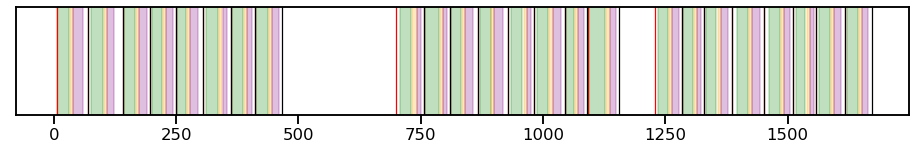

In [12]:
# Plot the task structure for the whole recording
plot_task_structure(nwbfile.trials)

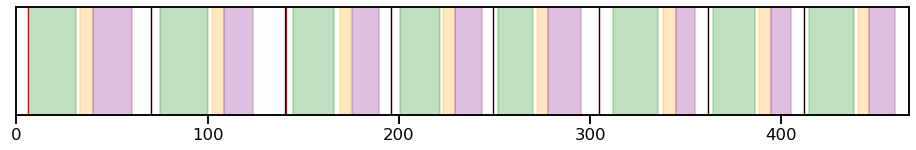

In [13]:
# Plot the task structure for a single block
plot_task_structure(nwbfile.trials, xlim=[0, nwbfile.trials.stop_time[7]])

## Position Data

In [14]:
# Extract the position data
pos = nwbfile.acquisition['position']['player_position']
pos

player_position pynwb.behavior.SpatialSeries at 0x47738974928560
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (25762, 2), type "<f8">
  description: Position of the subject in the arena.
  interval: 1
  reference_frame: corner
  resolution: -1.0
  timestamps: <HDF5 dataset "timestamps": shape (25762,), type "<f8">
  timestamps_unit: seconds
  unit: virtual units

#### Plot all position data

This includes self-navigation, and transport.

In [15]:
# Extract position timestamps and values
ptimes = pos.timestamps[:]
positions = pos.data[:].T

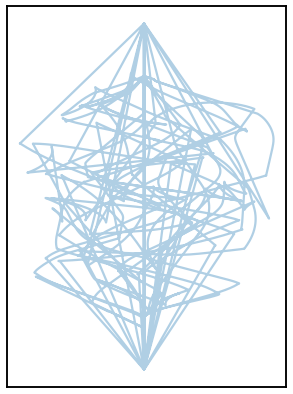

In [16]:
# Plot the map across all position traces
plot_positions(positions, figsize=(5, 7))

#### Select navigation only from navigation

In [17]:
# Get the navigation time ranges
nav_starts = nwbfile.trials.navigation_start[:]
nav_stops = nwbfile.trials.navigation_stop[:]

In [18]:
# Epoch position data to self-navigation
ptimes_trials, positions_trials = epoch_data_by_range(ptimes, positions, nav_starts, nav_stops)

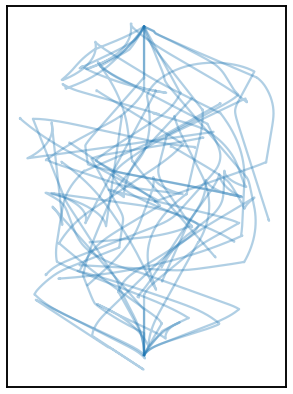

In [19]:
# Plot navigation-trial level position data
plot_positions(positions_trials, figsize=(5, 7))

In [20]:
# Get boundary ranges
x_boundary = nwbfile.acquisition['boundaries']['x_range'].data[:]
z_boundary = nwbfile.acquisition['boundaries']['z_range'].data[:]

In [21]:
# Check position ranges & compare to boundaries
print('X data range: \t{:6.2f} - {:6.2f}'.format(np.min(pos.data[0, :]), np.max(pos.data[0, :])))
print('Z data range: \t{:6.2f} - {:6.2f}'.format(np.min(pos.data[1, :]), np.max(pos.data[1, :])))
print()
print('X boundary: \t{:6.2f} - {:6.2f}'.format(*x_boundary))
print('Z boundary: \t{:6.2f} - {:6.2f}'.format(*z_boundary))

X data range: 	384.59 - 410.60
Z data range: 	384.59 - 410.60

X boundary: 	349.85 - 419.85
Z boundary: 	308.00 - 409.34


#### Check speed

In [22]:
# Get speed
speed = nwbfile.processing['position_measures']['speed'].data[:]

#### Check position samples from across navigation

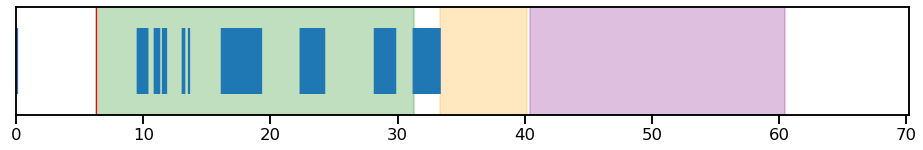

In [23]:
# Check when position times are samples across a single trial
plot_task_structure(nwbfile.trials, xlim=[0, nwbfile.trials.stop_time[0]])
trial_ptimes = get_value_by_time_range(ptimes, ptimes, 0, nwbfile.trials.stop_time[0])
plt.eventplot(trial_ptimes)

## Occupancy

In [24]:
# Compute occupancy values
occ = compute_occupancy(positions, ptimes, bins, speed, set_nan=True)

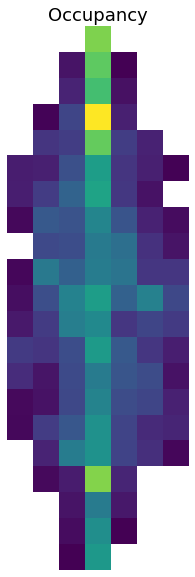

In [25]:
# Plot the occupancy
plot_heatmap(occ, transpose=True, title="Occupancy", figsize=(10, 10))

## Stimuli

In [26]:
# Collect chest positions
chest_pos = nwbfile.acquisition['stimuli']
chest_xs, chest_ys = chest_pos['chest_positions'].data[:].T

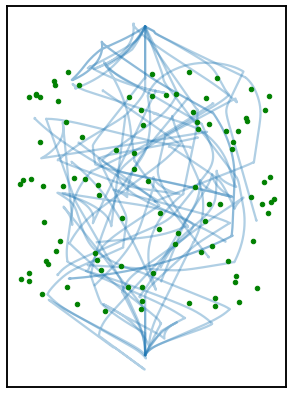

In [27]:
# Plot the subject positions, overlaid with chest positions
plot_positions(positions_trials, alpha=0.5, figsize=(5, 7))
plt.gca().plot(chest_xs, chest_ys, '.g');

In [28]:
# Collect and check which trial each trial is in
chest_trials = nwbfile.trials.chest_trials[:]
chest_trials

array([ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,
        4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,
        8,  8,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12,
       12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16,
       17, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 20, 20, 20, 20, 21,
       21, 21, 21, 22, 22, 22, 22, 23, 23, 23, 23])

### Trial-by-Trial

In the following representation:
- purple dots are the trial start location
- orange dots are the trial end location (where they do recall from)
- green dots are the chest locations

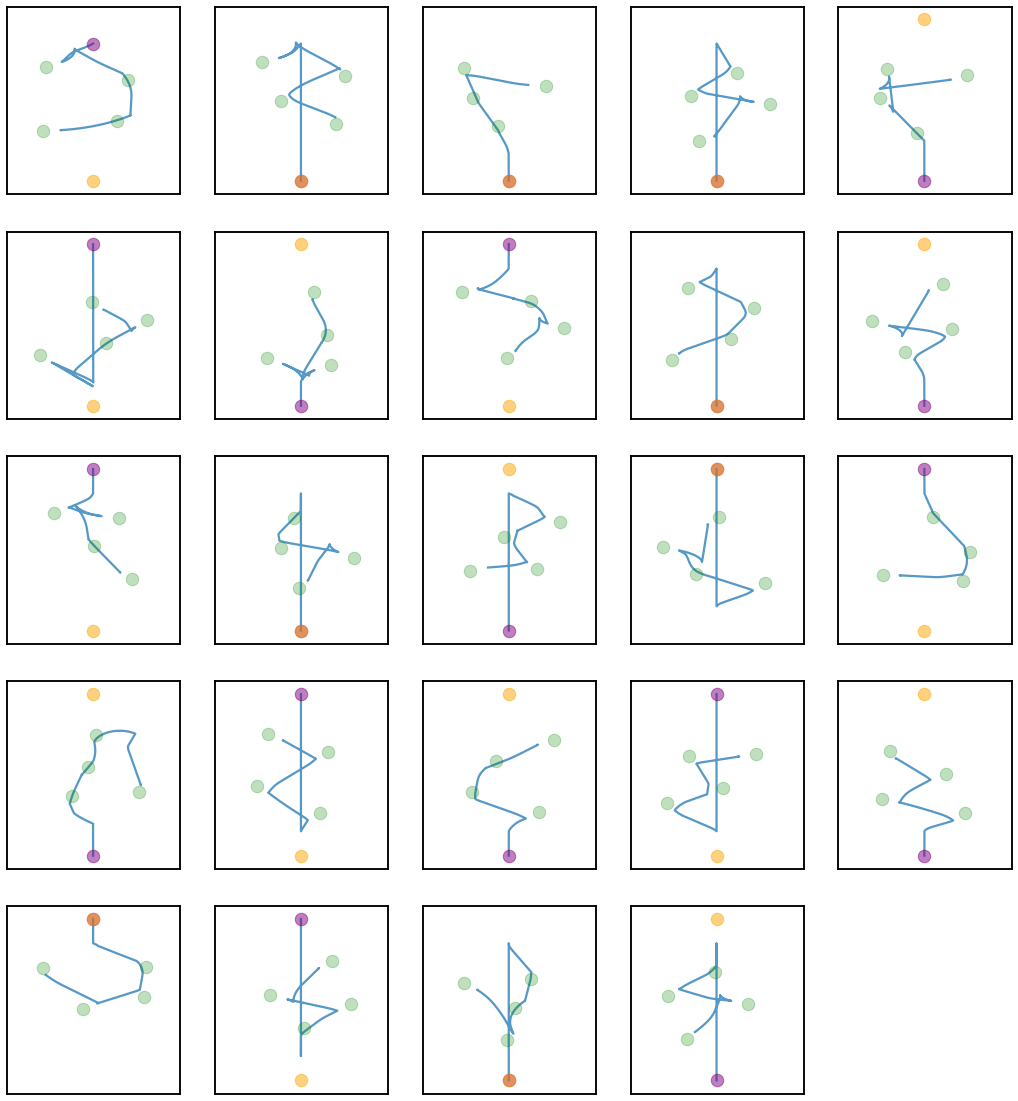

In [29]:
# Plot the trajectories for each trial
for t_ind, ax in zip(range(n_trials), make_axes(n_trials)):
    
    t_st = nwbfile.trials['start_time'][t_ind]
    ch_openings = nwbfile.trials['chest_opening_time'][t_ind]
    t_en = nwbfile.trials['stop_time'][t_ind]
    last_ch = ch_openings[-1]
        
    # Plot the position traces
    t_time, t_pos = get_value_by_time_range(ptimes, positions, t_st, last_ch)
    plot_positions(t_pos, alpha=0.75, ax=ax)

    # Plot the trial start position (purple)
    ax.plot(*t_pos[:, 0], '.', color='purple', ms=25, alpha=0.5)
    
    # Plot the trial end position
    end_point = get_value_by_time(ptimes, positions, t_en)
    ax.plot(*end_point, '.', color='orange', ms=25, alpha=0.5)
    
    # Plot the chest locations
    t_mask = chest_trials == t_ind
    ax.plot(chest_xs[t_mask], chest_ys[t_mask], '.g', ms=25, alpha=0.25)
    
    # Set x & y limits to the terrain range, expanding z to include the towers
    ax.set_xlim(*x_boundary)
    ax.set_ylim(z_boundary[0]-35, z_boundary[1]+35)

### Recall Selector

In [30]:
# Get the position traces of the recall selector
recall_pos = nwbfile.acquisition['recall']['selector'].data[:].T

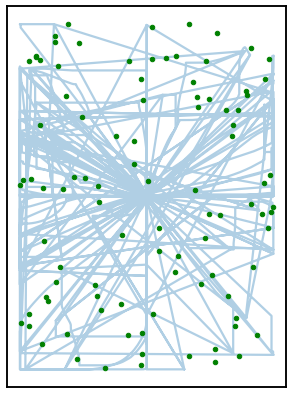

In [31]:
# Plot the positions of the recall selector, overlaid with chest positions
landmarks = {'positions' : np.array([chest_xs, chest_ys]), 'color' : 'g'}
plot_positions(recall_pos, landmarks=landmarks, figsize=(5, 7))

## Trials

In [32]:
# Check the data available in the NWB trials section
nwbfile.trials

trials pynwb.epoch.TimeIntervals at 0x47738975125664
Fields:
  colnames: ['start_time' 'stop_time' 'chest_opening_time' 'chest_recall_start'
 'chest_recall_stop' 'chest_rotation_start' 'chest_rotation_stop'
 'chest_trials' 'confidence_prompt_time' 'confidence_response'
 'confidence_response_time' 'correct' 'distractor_correct'
 'distractor_start' 'distractor_stop' 'error' 'feedback_start'
 'feedback_stop' 'full_chest' 'homebase_transport_start'
 'homebase_transport_stop' 'n_chests' 'n_treasures' 'navigation_start'
 'navigation_stop' 'recall_start' 'recall_stop' 'recall_trials'
 'response_time' 'scorescreen_start' 'scorescreen_stop' 'stimulus'
 'tower_transport_start' 'tower_transport_stop']
  columns: (
    start_time <class 'hdmf.common.table.VectorData'>,
    stop_time <class 'hdmf.common.table.VectorData'>,
    chest_opening_time_index <class 'hdmf.common.table.VectorIndex'>,
    chest_opening_time <class 'hdmf.common.table.VectorData'>,
    chest_recall_start_index <class 'hdmf.com

In [33]:
# Check event names
event_names = nwbfile.trials.colnames
print(event_names)

('start_time', 'stop_time', 'chest_opening_time', 'chest_recall_start', 'chest_recall_stop', 'chest_rotation_start', 'chest_rotation_stop', 'chest_trials', 'confidence_prompt_time', 'confidence_response', 'confidence_response_time', 'correct', 'distractor_correct', 'distractor_start', 'distractor_stop', 'error', 'feedback_start', 'feedback_stop', 'full_chest', 'homebase_transport_start', 'homebase_transport_stop', 'n_chests', 'n_treasures', 'navigation_start', 'navigation_stop', 'recall_start', 'recall_stop', 'recall_trials', 'response_time', 'scorescreen_start', 'scorescreen_stop', 'stimulus', 'tower_transport_start', 'tower_transport_stop')


In [34]:
# Check the number of trials in the dataset
n_trials = len(nwbfile.trials)
print('Number of trials: {}'.format(n_trials))

Number of trials: 24


In [35]:
# Get the trial information as a dataframe
behav = nwbfile.trials.to_dataframe()
behav.head()

,start_time,stop_time,chest_opening_time,chest_recall_start,chest_recall_stop,chest_rotation_start,chest_rotation_stop,chest_trials,confidence_prompt_time,confidence_response,...,navigation_stop,recall_start,recall_stop,recall_trials,response_time,scorescreen_start,scorescreen_stop,stimulus,tower_transport_start,tower_transport_stop
id,,,,,,,,,,,,,,,,,,,,,
0,6.244034,70.220378,"[13.948075294494629, 19.88310718536377, 25.451...","[43.06123208999634, 50.93227458000183, 56.3413...","[49.50926685333252, 54.89029598236084, 60.4443...","[13.206071138381958, 19.223103523254395, 24.20...","[13.946074962615967, 19.882107257843018, 25.45...","[0, 0, 0, 0]","[40.37321758270264, 49.578267097473145, 54.910...","[maybe, maybe, maybe]",...,31.305169,40.372218,60.458326,"[0, 0, 0]","[49.308265686035156, 54.688294649124146, 60.24...",69.061372,70.220378,"[Face_43, Face_45, Face_34]",31.305169,33.304179
1,70.228379,140.762759,"[79.47542834281921, 86.85546803474426, 93.5495...","[111.69860219955444, 118.57863926887512, 122.8...","[117.30163240432739, 121.14065289497375, 123.9...","[79.2044267654419, 86.48746609687805, 93.16750...","[79.47542834281921, 86.85546803474426, 93.5495...","[1, 1, 1, 1]","[108.79658651351929, 117.44063305854797, 121.2...","[maybe, maybe, maybe]",...,100.304541,108.796587,124.001668,"[1, 1, 1]","[117.09963130950928, 120.93965196609497, 123.7...",140.018755,140.761759,"[Face_3, Face_38, Face_8]",100.304541,102.554553
2,140.769759,195.939056,"[151.46881651878357, 155.52383852005005, 159.5...","[177.80495858192444, 184.25399327278137]","[182.78898549079895, 189.82302331924438]","[151.12881469726562, 155.38383769989014, 159.4...","[151.46881651878357, 155.52383852005005, 159.5...","[2, 2, 2, 2]","[175.33194518089294, 182.83798575401306]","[maybe, maybe]",...,166.173896,175.331945,189.858024,"[2, 2]","[182.58898425102234, 189.62102222442627]",195.051052,195.939056,"[Face_5, Face_32]",166.173896,169.062912
3,195.946056,249.401345,"[203.87509894371033, 208.31212282180786, 213.2...","[232.2792522907257, 238.34228467941284]","[236.10527276992798, 243.3123116493225]","[203.6460976600647, 208.1871223449707, 213.026...","[203.87509894371033, 208.31212282180786, 213.2...","[3, 3, 3, 3]","[229.2942361831665, 236.2452735900879]","[maybe, maybe]",...,221.275193,229.294236,243.451312,"[3, 3]","[235.9042718410492, 243.11131072044373]",248.561340,249.401345,"[Face_15, Face_30]",221.275193,223.121203
4,249.408345,304.697643,"[255.44837713241577, 259.2893977165222, 263.24...","[280.17351031303406, 289.15855884552, 292.7755...","[287.63055062294006, 291.2615702152252, 295.30...","[254.74737334251404, 259.1493971347809, 263.14...","[255.44837713241577, 259.2893977165222, 263.24...","[4, 4, 4, 4]","[277.9314982891083, 287.8105516433716, 291.358...","[maybe, maybe, maybe]",...,270.181457,277.931498,295.344592,"[4, 4, 4]","[287.4295494556427, 291.06056928634644, 295.10...",303.904638,304.696643,"[Face_29, Face_13, Face_20]",270.181457,272.362468


#### Confidence

In [36]:
# Count confidence answers
conf_counts = Counter(nwbfile.trials.confidence_response.data[:])

In [37]:
# Fix confidence answers
for el in ['yes', 'maybe', 'no']:
    if el not in conf_counts:
        conf_counts[el] = 0

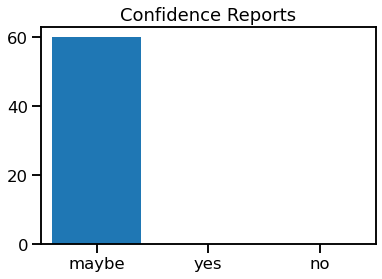

In [38]:
# Plot confidence answers
plot_bar(conf_counts.values(), conf_counts.keys(), title='Confidence Reports')

#### Response Error

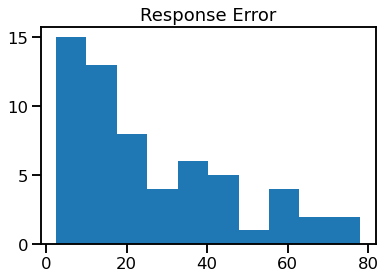

In [39]:
# Plot response error
plot_hist(nwbfile.trials.error.data[:], title='Response Error')

## Check Unit Data

Note that we only look at units that are marked to keep.

In [40]:
# Check the data available in the NWB units section
nwbfile.units

units pynwb.misc.Units at 0x47738975284768
Fields:
  colnames: ['channel' 'cluster' 'keep' 'location' 'wvID' 'spike_times' 'electrodes']
  columns: (
    channel <class 'hdmf.common.table.VectorData'>,
    cluster <class 'hdmf.common.table.VectorData'>,
    keep <class 'hdmf.common.table.VectorData'>,
    location <class 'hdmf.common.table.VectorData'>,
    wvID <class 'hdmf.common.table.VectorData'>,
    spike_times_index <class 'hdmf.common.table.VectorIndex'>,
    spike_times <class 'hdmf.common.table.VectorData'>,
    electrodes_index <class 'hdmf.common.table.VectorIndex'>,
    electrodes <class 'hdmf.common.table.DynamicTableRegion'>
  )
  description: Spike sorting solutions - done with oSort by Runnan Cao.
  id: id <class 'hdmf.common.table.ElementIdentifiers'>
  waveform_unit: volts

In [41]:
# Check how many units are available
n_units = len(nwbfile.units)
print('Number of units: {}'.format(n_units))

Number of units: 81


In [42]:
# Check the total number of spikes
print('Total number of spikes: {}'.format(nwbfile.units.spike_times.shape[0]))

Total number of spikes: 187680


In [43]:
# Count the number of units per wire
channel_counts = Counter(nwbfile.units.channel[:])
counts_per_wire = Counter(channel_counts.values())

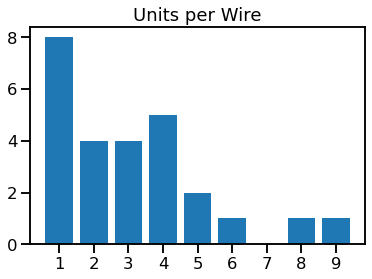

In [44]:
# Plot the distribution of units per wire
plt.bar(counts_per_wire.keys(), counts_per_wire.values())
plt.xticks(list(range(min(counts_per_wire.keys()), max(counts_per_wire.keys()) + 1)));
plt.title('Units per Wire');

#### Check Keep & Reject Neurons

In [45]:
# Check how many units are marked to keep
n_keep = sum(nwbfile.units.keep[:])
print('Number of keep neurons: {}'.format(n_keep))

Number of keep neurons: 57


In [46]:
# Get the indices of the neurons to keep
keep_inds = np.where(nwbfile.units.keep[:])[0]
assert len(keep_inds) == n_keep

In [47]:
# Get the indices of the neurons that are rejected
reject_inds = np.where((nwbfile.units.keep[:] - 1) * -1)[0]
assert len(reject_inds) + n_keep == n_units

In [48]:
# Calculate the average overall firing rate of each neuron
rates = [compute_spike_rate(nwbfile.units.get_unit_spike_times(s_ind)) \
         for s_ind in keep_inds]

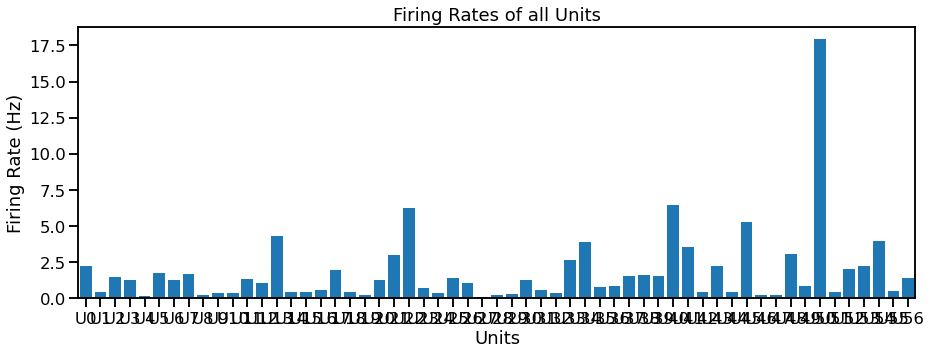

In [49]:
# Plot approximate firing rate for each unit
plot_unit_frs(rates, figsize=(15, 5))

In [50]:
# Collect session normalized spiking activity across all units
all_spikes = []
for uind in keep_inds:
    all_spikes.append(nwbfile.units.get_unit_spike_times(uind))

In [51]:
# Set start and stop time of the task (note that 0 is task start time)
st = 0
en = nwbfile.trials.stop_time[-1]

In [52]:
# Compute the task length, in minutes
task_len = convert_sec_to_min(en)

In [53]:
# Check the task / recording length, based on unit time
print('Task length: {:1.2f} minutes'.format(task_len))

Task length: 27.87 minutes


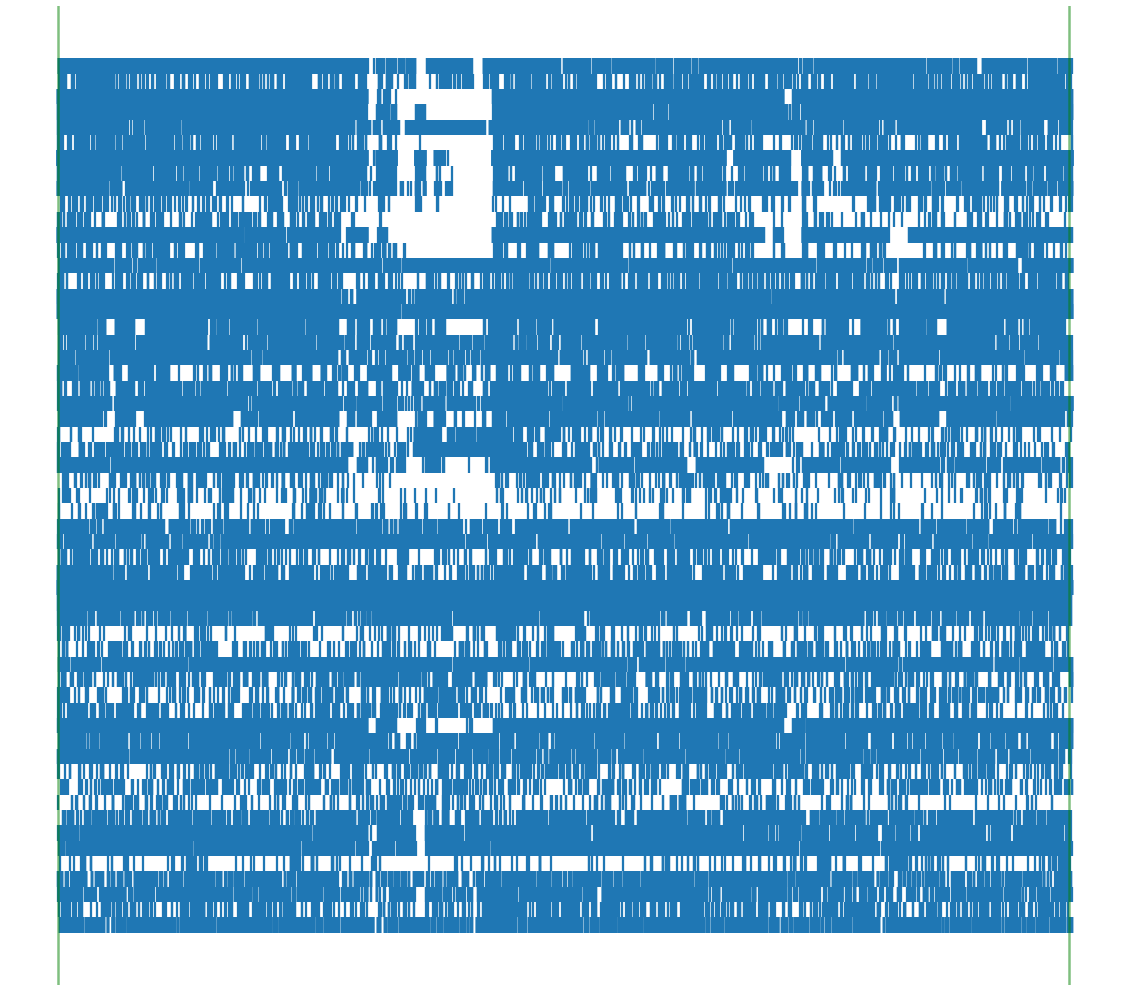

In [54]:
# Plot the session-level raster plot across all units together
plot_rasters(all_spikes, vline=[st, en], figsize=(20, 18))

In [55]:
# # Print out the whole-session spike raster for each neuron separately
# for uind in keep_inds:
#     spikes = nwbfile.units.get_unit_spike_times(uind)
#     plot_rasters(spikes, show_axis=True, figsize=(16, 2))